In [1]:
import torch
import numpy as np
import copy
import pickle
import time
from torchvision import transforms
import matplotlib.pyplot as plt

from clip_utils.clip_loss_nada import CLIPLoss
from training_utils.training_utils import get_lr
from get3d_utils import constructGenerator, save_textured_mesh, eval_get3d_angles, generate_random_camera, generate_rotate_camera_list

In [2]:
def preprocess_rgb(array):
    img = array
    img = transforms.Normalize(mean=[-1.0, -1.0, -1.0], std=[2.0, 2.0, 2.0])(img)
    img = img.transpose(1, 3)
    img = img.transpose(1, 2)
    img = img.clip(0., 1.)
    return img.cpu().numpy()

In [3]:
with open('test.pickle', 'rb') as f:
        generator_args = pickle.load(f)

G_ema = constructGenerator(**generator_args)

constructing
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
==> resume from pretrained path pretrained_model/shapenet_car.pt


In [4]:
torch.manual_seed(0)

In [5]:
text_prompt = 'Sports Car'

loss_types = ['global', 'pae', 'directional']
#loss_types = ['pae']

In [6]:
n_samples = 30

z_geo = torch.randn(n_samples, 512).to('cuda')
z_tex = torch.randn(n_samples, 512).to('cuda')

with torch.no_grad():
    ws_geo = G_ema.mapping_geo(z_geo, c=torch.ones(1, device='cuda'), truncation_psi=0.7, update_emas=False)
    ws_tex = G_ema.mapping(z_tex, c=torch.ones(1, device='cuda'), truncation_psi=0.7, update_emas=False)

In [8]:

for i, _ in enumerate(ws_geo):
    print(i)
    for loss_type in loss_types:
        geo_edited, tex_edited = latent_code_opt(z_geo[i].unsqueeze(0), z_tex[i].unsqueeze(0), text_prompt=text_prompt, n_epochs=100, lmbda_1=0.00005, lmbda_2=1.0, intermediate_space=True, loss_type=loss_type)
        with torch.no_grad():
            save_textured_mesh(G_ema, geo_edited.to('cuda'), tex_edited.to('cuda'), f'latent_opt_meshes_saved/{loss_type}/{text_prompt}/{i}.obj')
        torch.cuda.empty_cache()

0


/home/windows-ssh/git/GET3D/get3d_utils.py:351: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  camera_theta = torch.range(0, n_camera - 1, device='cuda').unsqueeze(dim=-1) / n_camera * math.pi * 2.0
/home/windows-ssh/git/GET3D/get3d_utils.py:351: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  camera_theta = torch.range(0, n_camera - 1, device='cuda').unsqueeze(dim=-1) / n_camera * math.pi * 2.0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [9]:

cameras = generate_rotate_camera_list()
cameras = [cameras[4]]
imgs = []
for i, _ in enumerate(ws_geo):
    with torch.no_grad():
        img_original = eval_get3d_angles(G_ema, ws_geo[i].unsqueeze(0), ws_tex[i].unsqueeze(0), cameras=cameras, intermediate_space=True).cpu()
        imgs.append(img_original)
    for loss_type in loss_types:
        geo_edited, tex_edited = latent_code_opt(z_geo[i].unsqueeze(0), z_tex[i].unsqueeze(0), text_prompt=text_prompt, n_epochs=100, lmbda_1=0.00001, lmbda_2=0.1, intermediate_space=True, loss_type=loss_type)
        with torch.no_grad():
            img_edited = eval_get3d_angles(G_ema, geo_edited.to('cuda'), tex_edited.to('cuda'), cameras=cameras, intermediate_space=True).cpu()
            imgs.append(img_edited)
        torch.cuda.empty_cache()
imgs = torch.cat(imgs)

/home/windows-ssh/git/GET3D/get3d_utils.py:351: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  camera_theta = torch.range(0, n_camera - 1, device='cuda').unsqueeze(dim=-1) / n_camera * math.pi * 2.0


In [10]:
with torch.no_grad():
    preprocessed_imgs = preprocess_rgb(imgs)

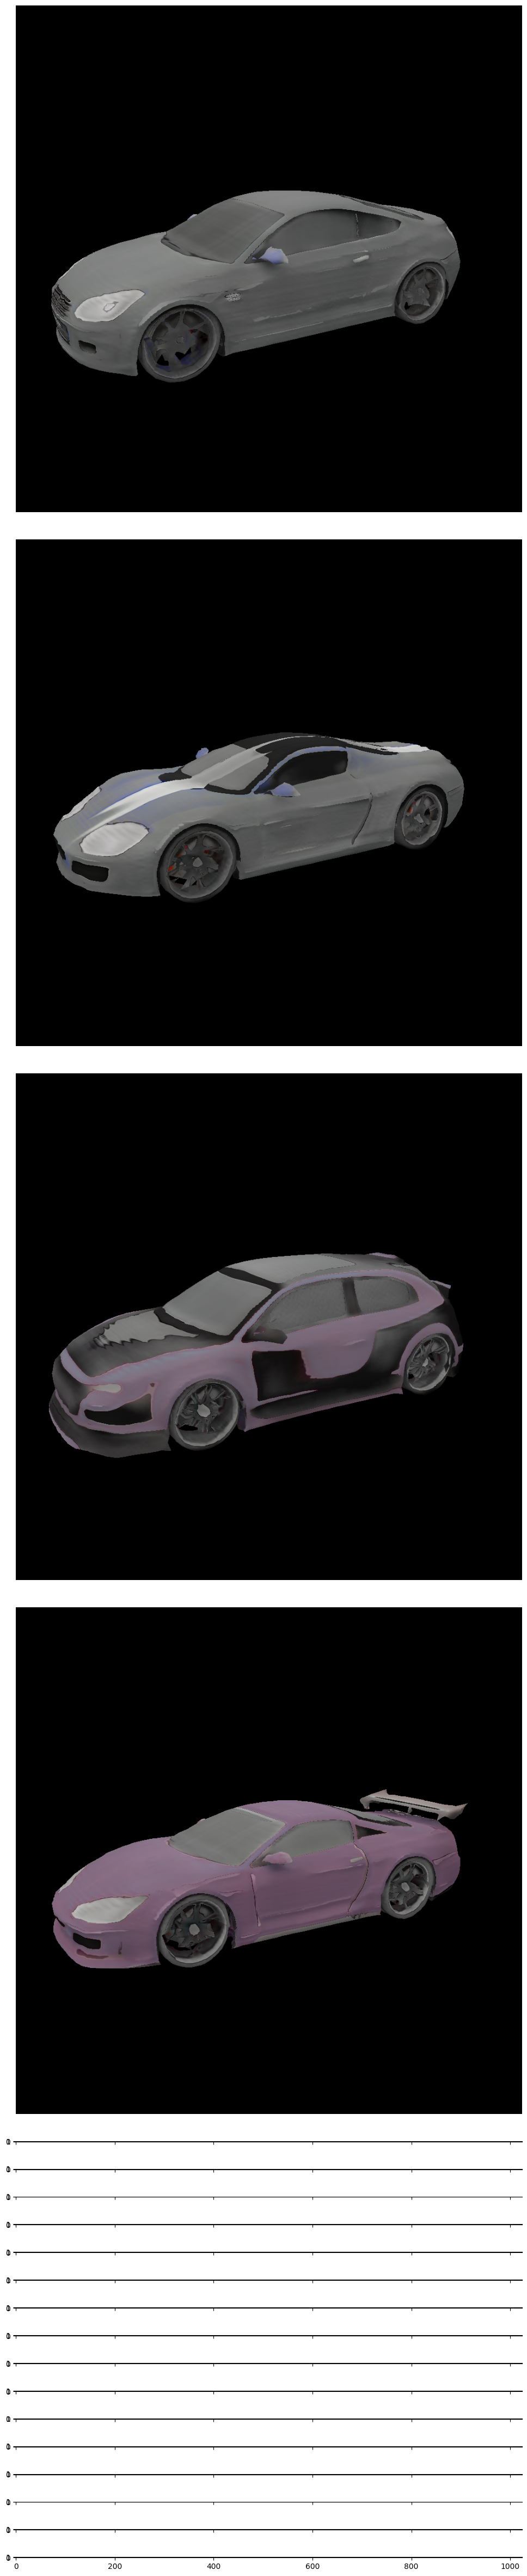

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid

n_show = 10

fig = plt.figure(figsize=(12., 200.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(n_show * (len(loss_types) + 1), len(cameras)),
                 axes_pad=(0.1, 0.5),
                 )

for i, (ax, im) in enumerate(zip(grid, preprocessed_imgs[:n_show * (len(loss_types) + 1) * len(cameras)])):
    ax.axis('off')
    #ax.set_title(f'{i}')
    ax.imshow(im)

In [7]:
def latent_code_opt(data_geo_z, data_tex_z, text_prompt, n_epochs=5, lmbda_1=0.0015, lmbda_2=0.0015, intermediate_space=False, loss_type = 'global', corpus_type='body_type'):
    camera_list = generate_rotate_camera_list()

    if corpus_type == 'body_type':
        corpus = ['Sports Car', 'SUV', 'Hatchback', 'Sedan']
    elif corpus_type == 'textures':
        corpus = ["Paint", "Glass", "Chrome", "Rubber", "Leather", "Plastic", "Carbon Fiber", "Fabric", "Metal", "Rust", "Dirt", "Decal", "Reflective Surfaces", "Ice", "Wood", "Neon", "Matte Black", "Carbon Ceramic"]
    else:
        raise NotImplementedError

    clip_loss = CLIPLoss('car', text_prompt, corpus=corpus, aux_string='')

    min_latent = None
    min_loss = float('inf')

    save_n = 100
    n_save = int(n_epochs)/save_n

    learning_rate = 5e-2
    if intermediate_space:
        with torch.no_grad():
            data_geo = G_ema.mapping_geo(data_geo_z, c=torch.ones(1, device='cuda'), truncation_psi=0.7, update_emas=False).detach()
            data_tex = G_ema.mapping(data_tex_z, c=torch.ones(1, device='cuda'), truncation_psi=0.7, update_emas=False).detach()
        latent_geo = data_geo[0][0].detach().unsqueeze(0).clone()
        latent_tex = data_tex[0][0].detach().unsqueeze(0).clone()
    else:
        data_geo = data_geo_z.detach().clone()
        data_tex = data_tex_z.detach().clone()
        latent_geo = data_geo_z.detach().clone()
        latent_tex = data_tex_z.detach().clone()

    original_latents = (data_geo.detach().clone().cpu(), data_tex.detach().clone().cpu())

    latent_geo.requires_grad_(True)
    latent_tex.requires_grad_(True)

    z_optim = torch.optim.Adam([latent_geo, latent_tex], lr=learning_rate, betas=(0.9, 0.99))
    
    for i in range(n_epochs):

        cameras = generate_random_camera(1, n_views=10)
        cameras = cameras.unsqueeze(0)
        cameras = cameras.transpose(0, 2)
        # cameras = generate_rotate_camera_list()

        with torch.no_grad():
            output_original = eval_get3d_angles(G_ema,  data_geo_z, data_tex_z, cameras=cameras,  intermediate_space=False)

        # Get output of GET3D on latents
        #output = eval_get3d_weights(g_ema, geo_z, tex_z, 0)
        if intermediate_space:
            output_edited = eval_get3d_angles(G_ema, latent_geo.unsqueeze(0).repeat(1, 22, 1), 
                                       latent_tex.unsqueeze(0).repeat(1, 9, 1),
                                       cameras=cameras, intermediate_space=intermediate_space)
        else:
            output_edited = eval_get3d_angles(G_ema, latent_geo, latent_tex, cameras=cameras, intermediate_space=intermediate_space)
        # Get CLIP Loss
        # loss_clip = clip_loss.directional_projection_loss(output_edited, output_edited).mean()
        # loss_clip = clip_loss(output_edited, output_edited)
        # loss_clip = clip_loss.projection_embedding_loss(output_edited)
        if loss_type == 'global':
            loss_clip = clip_loss.global_loss(output_edited)
        elif loss_type == 'pae':
            loss_clip = clip_loss.projection_augmentation_loss_nada(output_original, output_edited, power=8)
        elif loss_type == 'directional':
            loss_clip = clip_loss.directional_loss(output_original, output_edited).sum()
        else:
            raise NotImplementedError
        # loss_clip = clip_loss(output_original, output_edited).mean()

        # Control similarity to original latents
        loss_geo = 0
        loss_tex = 0

        loss_geo = lmbda_1 * ((latent_geo - data_geo) ** 2).sum()
        loss_tex = lmbda_2 * ((latent_tex - data_tex) ** 2).sum()

        loss = loss_clip + loss_geo + loss_tex # + lmbda_geo_deviation * (geo_z ** 2).sum() + lmbda_tex_deviation * (tex_z ** 2).sum()
 
        # Backpropagation
        loss.backward()

        # Update Optimizer
        z_optim.step()
        z_optim.zero_grad()

        with torch.no_grad():
            if loss.item() < min_loss:
                min_loss = loss.item()
                min_latent = (latent_geo.detach().cpu(), latent_tex.detach().cpu())

            # res_loss.append((loss.item(), loss_geo.item(), loss_clip.item()))

            # if i % n_save == 0:
            #     cur_output = output_edited.detach().clone()
            #     edited_images.append(cur_output[4].cpu().unsqueeze(0))

            # edited_latents.append((latent_geo.detach().cpu(), latent_tex.detach().cpu()))
    if intermediate_space:
        return min_latent[0].unsqueeze(0).repeat(1, 22, 1), min_latent[1].unsqueeze(0).repeat(1, 9, 1)
    else:
        return min_latent[0], min_latent[1]


   

In [3]:
with open('test.pickle', 'rb') as f:
        c = pickle.load(f)
    
G_ema = constructGenerator(**c)

torch.manual_seed(0)

# Parameters
lmbda_1 = 0.0001
lmbda_2 = 0.1
text_prompt= "Sports Car"
loss_type_= "pae"
n_epochs = 3
intermediate_space=True

z = torch.randn([30, 512], device='cuda')[0].unsqueeze(0)  # random code for geometry
tex_z = torch.randn([30, 512], device='cuda')[0].unsqueeze(0)  # random code for texture

original, edited, loss, min_latent, edited_images = train_eval(G_ema, z, tex_z, text_prompt, n_epochs=n_epochs, lmbda_1=lmbda_1, lmbda_2=lmbda_2, intermediate_space=intermediate_space, loss_type=loss_type_)


constructing
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
==> resume from pretrained path pretrained_model/shapenet_car.pt


/home/windows-ssh/git/GET3D/get3d_utils.py:351: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  camera_theta = torch.range(0, n_camera - 1, device='cuda').unsqueeze(dim=-1) / n_camera * math.pi * 2.0


0
1
2


In [4]:
 with torch.no_grad():
        G_ema.eval()
        cameras = generate_rotate_camera_list()
        img_original = eval_get3d_angles(G_ema, original[0].to('cuda'), original[1].to('cuda'), cameras=cameras, intermediate_space=intermediate_space).cpu()
        img_edited = eval_get3d_angles(G_ema, min_latent[0].to('cuda'), min_latent[1].to('cuda'), cameras=cameras, intermediate_space=intermediate_space).cpu()
        #save_textured_mesh(G_ema, original[0].to('cuda'), original[1].to('cuda'), f'meshes_saved/output_{random_seed}_original.obj')
        #save_textured_mesh(G_ema, min_latent[0].to('cuda'), min_latent[1].to('cuda'), f'meshes_saved/output_{random_seed}_{text_prompt_}_{loss_type_}.obj')
        # result.append({'Original': img_original, 'Edited': img_edited, 'Loss': loss, 'Original Latent': original, 'Edited Latent': min_latent, 'Edited Images': edited_images})
    # with open(f'latent_transform_adam_results_pae/output_img_{random_seed}_{lmbda_1}_{lmbda_2}_{text_prompt}_{n_epochs}_{time.time()}.pickle', 'wb') as f:
    #     pickle.dump(result, f)
    
    # images_latents = {'Original Image': img_original, 'Edited Image': img_edited, 'Original Latent': original, 'Edited Latent': min_latent, 'Loss': loss}
    # with open(f'latents_saved/output_{random_seed}_{text_prompt}_{loss_type_}.pickle', 'wb') as f:
    #     pickle.dump(images_latents, f)
    


/home/windows-ssh/git/GET3D/get3d_utils.py:351: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  camera_theta = torch.range(0, n_camera - 1, device='cuda').unsqueeze(dim=-1) / n_camera * math.pi * 2.0
